In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# DATA ANALYSIS

Dataset shape: (50000, 2)

Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Average review length: 1309.43 characters
Average word count: 231.16 words


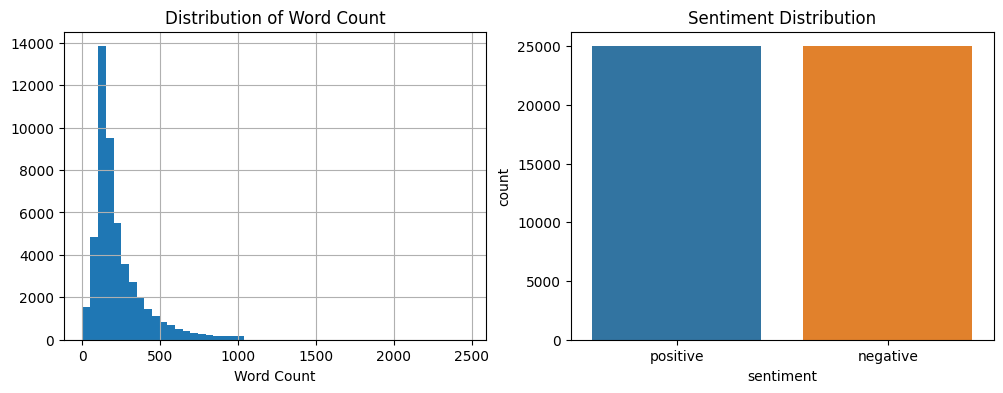

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Data distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Text length analysis
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

print(f"\nAverage review length: {df['review_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df['word_count'].hist(bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.show()

In [3]:
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

# Encode labels (positive=1, negative=0)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("Sample cleaned review:")
print(df['cleaned_review'].iloc[0][:200])

2025-06-22 12:12:27.581730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750594347.967393      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750594348.078890      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sample cleaned review:
one of the other reviewers has mentioned that after watching just  oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its bru


In [4]:
# Split the data
X = df['cleaned_review'].values
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

# Tokenization
MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"Training data shape: {X_train_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Train size: 30000
Validation size: 10000
Test size: 10000
Training data shape: (30000, 200)
Vocabulary size: 155390


# MODEL IMPLEMENTATION & TRANINING

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define constants
MAX_WORDS = 10000  
MAX_LEN = 200      

# Build model 
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build and display model info
model.build(input_shape=(None, MAX_LEN))
print(model.summary())
print(f"Total parameters: {model.count_params():,}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1750594374.497309      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750594374.498066      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Total parameters: 1,329,473


## TRAINING

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# GPU Configuration
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configured {len(gpus)} GPUs for memory growth")
    except RuntimeError as e:
        print(e)

# Training parameters
BATCH_SIZE = 128
EPOCHS = 10

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3, 
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=2, 
        factor=0.5,
        verbose=1
    ),
    ModelCheckpoint(
        'best_imdb_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print(f"Starting training with batch size {BATCH_SIZE}")
print("Training configuration ready...")

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Built with CUDA:  True
Physical devices cannot be modified after being initialized
Starting training with batch size 128
Training configuration ready...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6538 - loss: 0.6091
Epoch 1: val_accuracy improved from -inf to 0.84990, saving model to best_imdb_model.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 564ms/step - accuracy: 0.6542 - loss: 0.6088 - val_accuracy: 0.8499 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8415 - loss: 0.3822
Epoch 2: val_accuracy improved from 0.84990 to 0.85710, saving model to best_imdb_model.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 131s 559ms/step - accuracy: 0.8415 - loss: 0.3822 - val_accuracy: 0.8571 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step

## EVALUATION METRICS

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step
Validation Accuracy: 0.8571
Validation F1-Score: 0.8590
Validation Precision: 0.8477
Validation Recall: 0.8706

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      5000
      estive       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


TEST SET EVALUATION
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step
Test Accuracy: 0.8561
Test F1-Score: 0.8578
Test Precision: 0.8476
Test Recall: 0.8684

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      5000
    Positive       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86     

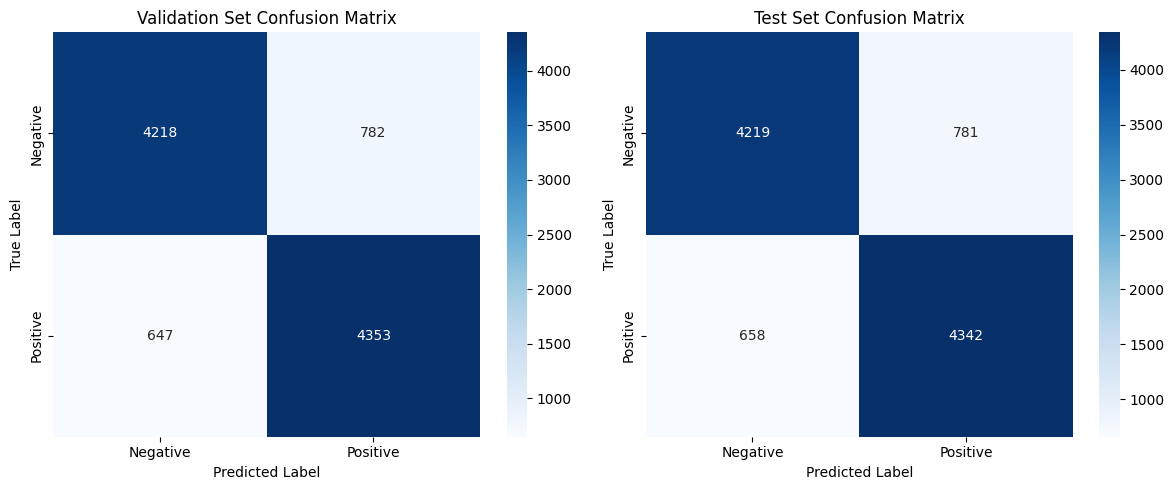

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate on validation set

# Make predictions
y_val_pred_proba = model.predict(X_val_pad)
y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()

# Calculate primary metrics 
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Negative', 'estive']))

# Confusion Matrix
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Validation Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test set evaluation
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Make predictions on test set
y_test_pred_proba = model.predict(X_test_pad)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive']))

# Test Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## VISUALIZATION

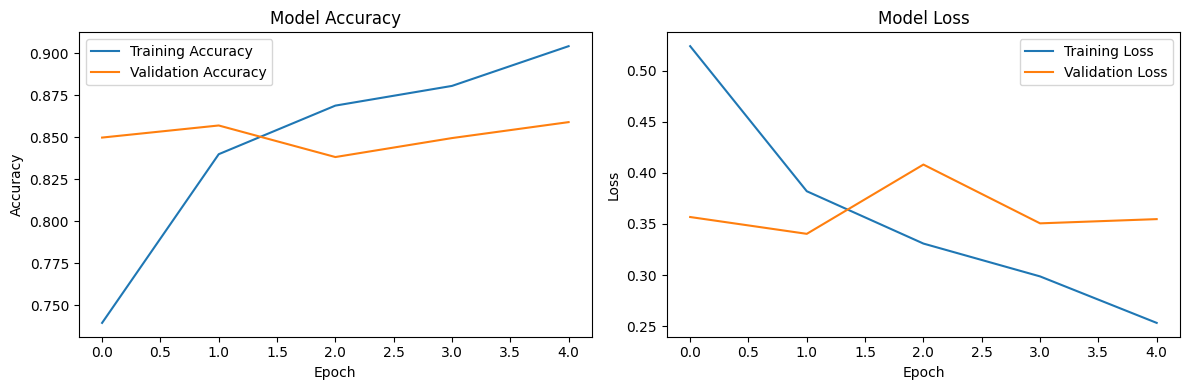

Model Architecture: Sequential LSTM with Embedding
Dataset: IMDB 50K Movie Reviews
Training samples: 30000
Validation samples: 10000
Test samples: 10000
Vocabulary size: 155390
Max sequence length: 200
Total parameters: 1,329,473

PERFORMANCE METRICS:
Validation Accuracy: 0.8571
Validation F1-Score: 0.8590
Test Accuracy: 0.8561
Test F1-Score: 0.8578

TRAINING DETAILS:
Epochs completed: 5
Early stopping triggered: Yes
Best model saved: best_imdb_model.h5
Final validation loss: 0.3404
Sample 1501: Actual=Negative, Predicted=Negative, Confidence=0.020
Review excerpt: i watched this movie on the grounds that amber benson rocks and nick stahl is generally pretty cool ...
--------------------------------------------------
Sample 3297: Actual=Negative, Predicted=Positive, Confidence=0.698
Review excerpt: from around the time europe began fighting world war ii until the wars end hollywood with significan...
--------------------------------------------------
Sample 3702: Actual=Positive, Predic

In [8]:
# Training history visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Summary Report 
print(f"Model Architecture: Sequential LSTM with Embedding")
print(f"Dataset: IMDB 50K Movie Reviews")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Max sequence length: {MAX_LEN}")
print(f"Total parameters: {model.count_params():,}")

print(f"\nPERFORMANCE METRICS:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print(f"\nTRAINING DETAILS:")
print(f"Epochs completed: {len(history.history['loss'])}")
print(f"Early stopping triggered: Yes")
print(f"Best model saved: best_imdb_model.h5")
print(f"Final validation loss: {min(history.history['val_loss']):.4f}")

# Sample predictions
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for i in sample_indices:
    actual = "Positive" if y_test[i] == 1 else "Negative"
    predicted = "Positive" if y_test_pred[i] == 1 else "Negative"
    confidence = y_test_pred_proba[i][0]
    print(f"Sample {i}: Actual={actual}, Predicted={predicted}, Confidence={confidence:.3f}")
    print(f"Review excerpt: {X_test[i][:100]}...")
    print("-" * 50)